In [1]:
from pathlib import Path
import configparser
from psycopg2 import connect
import pandas as pd
from datetime import datetime

CONFIG = configparser.ConfigParser()
CONFIG.read(str(Path.home().joinpath('db.cfg'))) #Creates a path to your db.cfg file
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)


In [62]:
sql = '''
SELECT
	a.divisionid,
	timestamputc, --timestamp without tz
	a.vdsid,
	lane,
	sensoroccupancyds,
	speedkmhdiv100,
	lengthmeterdiv100,
    --personoccupancy, --blank column
    --vehicletype --blank column
FROM vdsvehicledata AS a
LEFT JOIN vdsconfig AS b ON 
    a.vdsid = b.vdsid
    AND a.divisionid = b.divisionid
WHERE
    timestamputc >= '2023-06-14 00:00:00'
	AND timestamputc < '2023-06-15 00:00:00';
'''

with con: 
    data = pd.read_sql(sql, con)

/opt/jupyterhub/lib64/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [67]:
print(f"Number of rows: {data.shape[0]}")
print(data.head(10))

Number of rows: 11482706
   divisionid timestamputc    vdsid  lane  sensoroccupancyds  speedkmhdiv100  \
0           2   2023-06-14  5461264     1                NaN             NaN   
1           2   2023-06-14  5461265     1                NaN             NaN   
2           2   2023-06-14  5461266     1                NaN             NaN   
3           2   2023-06-14  5461267     1                NaN             NaN   
4           2   2023-06-14  5461268     1                NaN             NaN   
5           2   2023-06-14  5461269     1                NaN             NaN   
6           2   2023-06-14  5461270     1                NaN             NaN   
7           2   2023-06-14  5461271     1                NaN             NaN   
8           2   2023-06-14  5461272     1                NaN             NaN   
9           2   2023-06-14  5461273     1                NaN             NaN   

   lengthmeterdiv100  speed_binned_int  
0                NaN               NaN  
1           

<AxesSubplot:xlabel='speed_binned_int'>

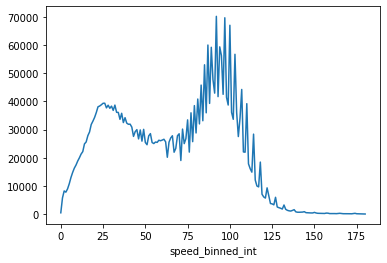

In [68]:
data['speed_binned_int'] = data['speedkmhdiv100'].map(lambda x: None if pd.isna(x) else round(x/100))
data.groupby('speed_binned_int')['speed_binned_int'].agg('count').plot()

In [84]:
speed_binned = data.groupby('speed_binned_int')['speed_binned_int'].agg(Count = 'count')
speed_binned.sort_values('Count', ascending=False, inplace=True)

In [85]:
speed_binned.head(10)

,Count
speed_binned_int,
92.0,70156
97.0,69647
100.0,66991
87.0,59980
94.0,59333
89.0,59184
103.0,56699
95.0,56205
85.0,52974


In [90]:
#calculate proportion for each value
data_grouped = data.groupby(['speed_binned_int', 'vdsid'])['speed_binned_int'].agg(Count = 'count').reset_index()
data_vds_total = data.groupby(['vdsid'])['vdsid'].agg(Count = 'count').reset_index()

In [94]:
data_proportion = data_grouped.merge(data_vds_total, right_on='vdsid', left_on = 'vdsid')

In [32]:
data['speed_binned'] = data['speedkmhdiv100'].map(lambda x: None if pd.isna(x) else round(x/10)/10)


Funky distribution with spikes spaced out every 3km. 

<AxesSubplot:xlabel='speed_binned'>

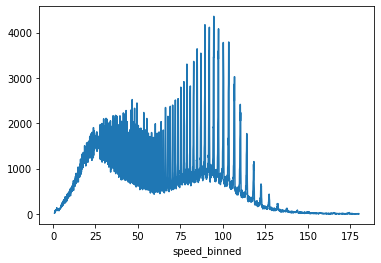

In [38]:
data.groupby('speed_binned')['speed_binned'].agg('count').plot()

Found some sensors (zeroed in on vdsid 224, 225) with percentage query have distributions around 3km/h buckets. 

<AxesSubplot:xlabel='speed_binned'>

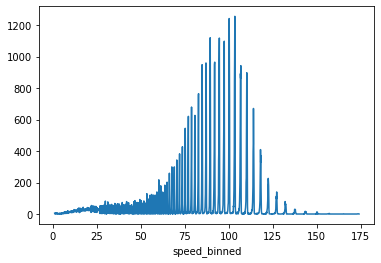

In [50]:
data_224_225 = data[[x in (224, 225) for x in data['vdsid']]]
data_224_225.groupby('speed_binned')['speed_binned'].agg('count').plot()

<AxesSubplot:xlabel='speed_binned'>

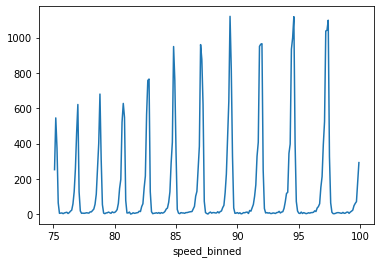

In [52]:
#zooming in: 
data_224_225[[x > 75 and x < 100 for x in data_224_225['speed_binned']]].groupby('speed_binned')['speed_binned'].agg('count').plot()

In [56]:
data.groupby(['vdsid'])['vdsid'].count()

vdsid
22          53398
23         155720
25         102752
26          63543
27         147388
28          80489
29          80906
31         163734
32          59619
33         123010
34          86152
39          21470
224         40606
225         44017
2000668     27654
2000699        79
2000708     22129
Name: vdsid, dtype: int64

Some of the sensors have more expected distributions. 

<AxesSubplot:xlabel='speed_binned'>

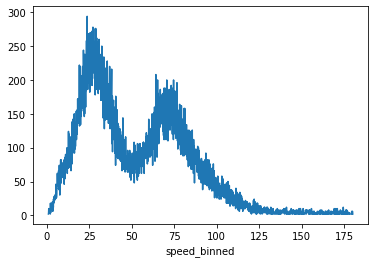

In [59]:
data[[x == 33 for x in data['vdsid']]].groupby('speed_binned')['speed_binned'].agg('count').plot()

The value columns are always blank for these sensors. 

In [2]:
sql = '''SELECT COUNT(*) 
FROM public.vdsvehicledata 
WHERE
    divisionid <> 2
    AND COALESCE(sensoroccupancyds, speedkmhdiv100, lengthmeterdiv100) is not null;'''

with con: 
    data = pd.read_sql(sql, con)

print(data)

/opt/jupyterhub/lib64/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


These columns are always blank, regardless of the detector. PSYCHE, NOT BLANK!

In [ ]:
sql = '''SELECT divisionid, COUNT(*) 
FROM public.vdsvehicledata 
WHERE COALESCE(personoccupancy, vehicletype) is not null
GROUP BY divisionid;'''

with con: 
    data = pd.read_sql(sql, con)

print(data)

The bike lane sensors on Yonge St have reasonable count data: 

In [ ]:
sql = "SELECT timestamputc::date, COUNT(*) FROM vdsvehicledata WHERE vdsid IN (5062301, 5062305) GROUP BY 1 ORDER BY 1"

with con: 
    data = pd.read_sql(sql, con)

print(data)